# Image processing tutorial

#### Part 1: Exploring individual images
#### Part 2: Data Representation and Dimensionality Reduction

# Part 1: Exploring individual images of biofilms

In this notebook, we provide a tutorial of how to properly call the functions build to extract various biofilm features. This includes :

- Finding the wrinkles
- Computing the percentage of wrinkle area
- Computing the number of spokes present in the biofilm, the median length of the spokes and the median distance of the spokes from the center
- Computing the average distance from spokes to the center of the biofilm


You will find all the necessary functions in the `.py` file `image_processing_functions.py`

In [1]:
# Additional python packages

from __future__ import print_function

from time import time
import logging
import os, urllib, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import cv2
from ggplot import *
import umap

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.manifold import TSNE

from image_processing_functions import * # Our functions


/usr/local/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


## Loading the data

For this tutorial, we will work on 6 different 5 days old biofilm images, all of each mutant.

In [2]:
day = 5
index = 1
size = 500
path = '/home/khalana/GitRepos/dsi-capstone/final_dataset/'
images = {}
names = []
for mutant in ['cco1cco2', 'dipA','pas9','phz','rmcA', 'wt']:
    name = '{}_{}_{}'.format(mutant, day, index)
    names.append(name)
    img_path = path + name + '.jpg'
    img = Image.open(img_path)
    img = img.resize((size, size))
    arr = np.array(img).astype('uint8')
    images[name] = arr
dic_features = {'biofilm' : names}

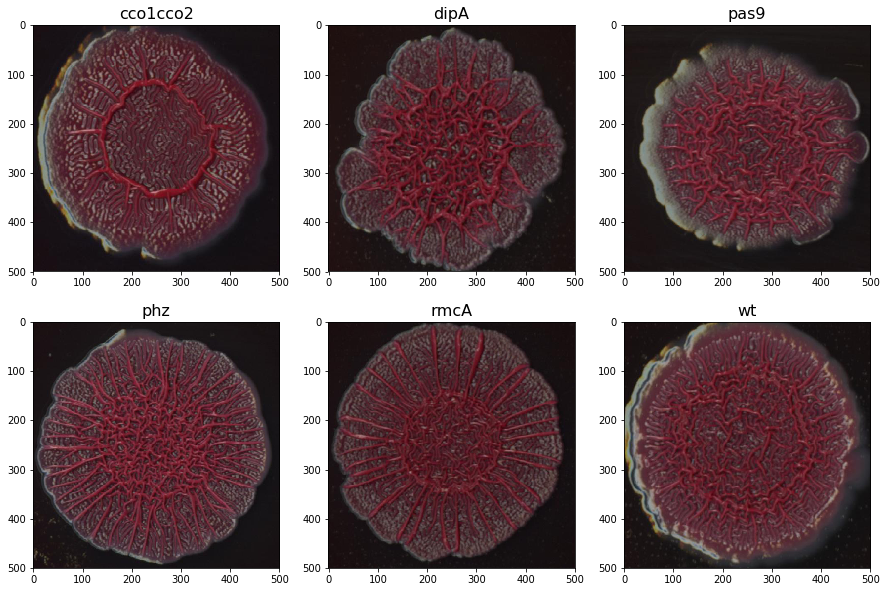

In [3]:
f, axarr = plt.subplots(2, 3, figsize = (15,10))
k = 0
for i in range(2) :
    for j in range(3) :
        axarr[i,j].imshow(images[names[k]])
        axarr[i,j].set_title(names[k].split('_')[0], fontsize=16)
        k += 1

## Getting the wrinkle class

In [4]:
images_wrinkle_class = {}
for name in names :
    images_wrinkle_class[name] = get_wrinkles(images[name], resize = size, background_is_black = True)

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:85: RuntimeWarning: divide by zero encountered in true_divide
  labels = ((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1] / X[:,2])) < 0.75) & (X[:,1] < 80) & (X[:,2] < 80) & ((X[:,0]/ (X[:,1] +  X[:,2])) > 1.0)


### Plotting wrinkle class

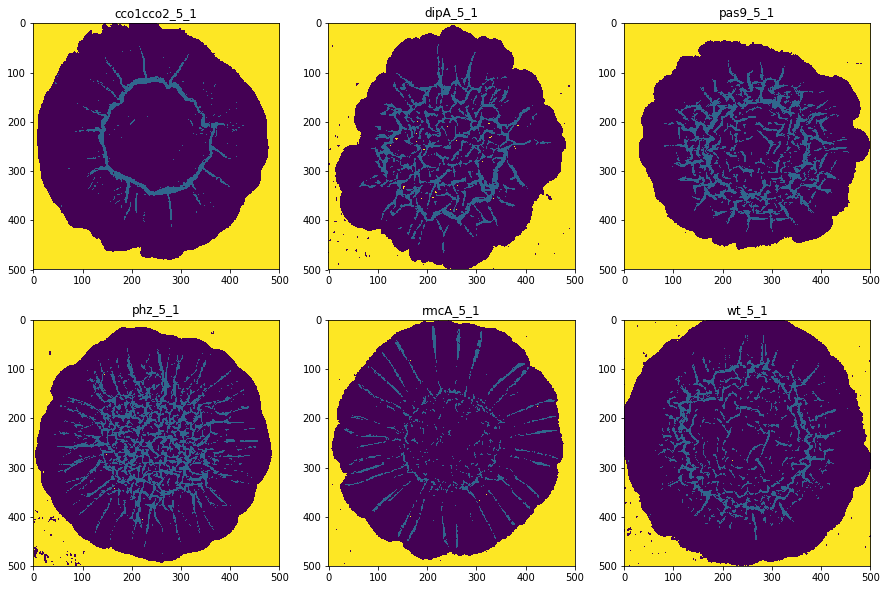

In [5]:
f, axarr = plt.subplots(2, 3, figsize = (15,10))
k = 0
for i in range(2) :
    for j in range(3) :
        axarr[i,j].imshow(images_wrinkle_class[names[k]][1])
        axarr[i,j].set_title(names[k])
        k += 1

### Computing percent wrinkled

In [6]:
percent_wrinkled = []
for name in names :
    percent_wrinkled.append(perc_wrinkled(images_wrinkle_class[name][0]))

dic_features['percent_wrinkled'] = percent_wrinkled

df_features = pd.DataFrame.from_dict(dic_features)
df_features

,biofilm,percent_wrinkled
0,cco1cco2_5_1,5.91
1,dipA_5_1,15.36
2,pas9_5_1,17.41
3,phz_5_1,18.64
4,rmcA_5_1,7.14
5,wt_5_1,10.90


## Detecting the spokes

In [7]:
images_spokes = {}
for name in names :
    images_spokes[name] = detect_spokes(images[name], img_wrinkle=images_wrinkle_class[name][1], resize = size)[0]

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:137: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (coords[3]-coords[1])/(coords[2]-coords[0])


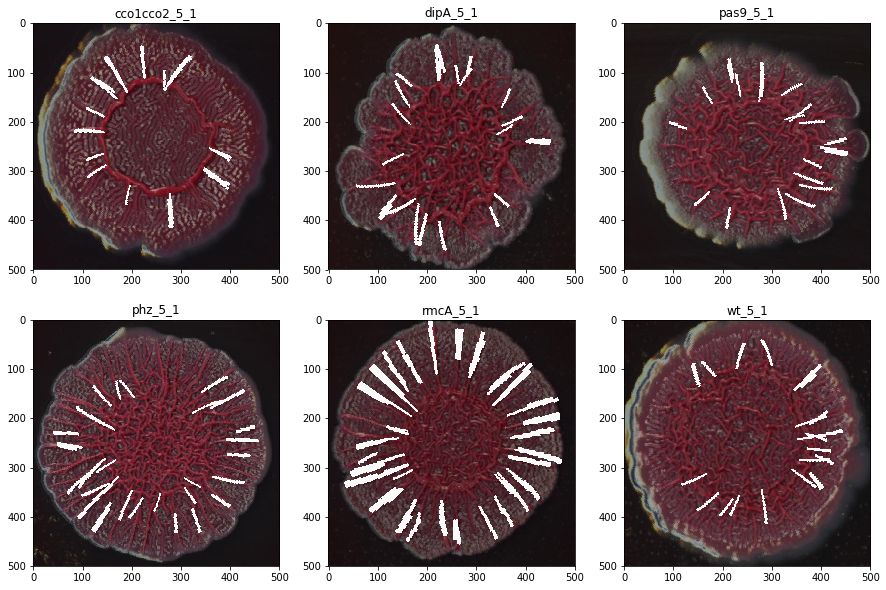

In [8]:
f, axarr = plt.subplots(2, 3, figsize = (15,10))
k = 0
for i in range(2) :
    for j in range(3) :
        axarr[i,j].imshow(images_spokes[names[k]])
        axarr[i,j].set_title(names[k])
        k += 1

### Computing number of spokes, median length of spokes and medium distance from center

In [9]:
n_spokes = []
median_spokes_length = []
median_dist_center = []
for name in names :
    _, n_spoke, median_length, median_dist = detect_spokes(images[name], img_wrinkle=images_wrinkle_class[name][1], resize = size)
    n_spokes.append(n_spoke)
    median_spokes_length.append(median_length)
    median_dist_center.append(median_dist)

dic_features['n_spokes'] = n_spokes
dic_features['median_spokes_length'] = median_spokes_length
dic_features['median_dist_center'] = median_dist_center

df_features = pd.DataFrame.from_dict(dic_features)
df_features

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:137: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (coords[3]-coords[1])/(coords[2]-coords[0])


,biofilm,percent_wrinkled,n_spokes,median_spokes_length,median_dist_center
0,cco1cco2_5_1,5.91,22,68.103300,158.0
1,dipA_5_1,15.36,25,65.375837,181.0
2,pas9_5_1,17.41,21,64.195015,144.0
3,phz_5_1,18.64,33,70.114193,155.0
4,rmcA_5_1,7.14,84,88.511362,170.5
5,wt_5_1,10.90,22,63.899552,150.0


# Part 2: Data exploration - full data set

## Loading all 4 and 5 days images

In [10]:
all_images={}
all_names=[]
for root, dirs, files in os.walk(path):
    for name in files:
        if int(name.split('_')[1]) > 3:
            mypath = os.path.join(root,name)
            img = Image.open(mypath, mode = 'r')
            img = img.resize((size, size))
            arr = np.array(img).astype('uint8')
            all_images[name.split('.')[0]] = arr
            img.close()
            all_names.append(name.split('.')[0])
            
dic_features = {'biofilm' : all_names}


## Extracting all features

Note that this cell takes a long time (30+ minutes) to process all images in the 'final_dataset' folder. 

In [11]:
percent_wrinkled = []
n_spokes = []
median_spokes_length = []
median_dist_center = []
all_images_wrinkle_class = {}
for name in all_names :
    all_images_wrinkle_class[name] = get_wrinkles(all_images[name], resize = size, background_is_black = True)
    percent_wrinkled.append(perc_wrinkled(all_images_wrinkle_class[name][0]))
    _, n_spoke, median_length, median_dist = detect_spokes(all_images[name],img_wrinkle=all_images_wrinkle_class[name][1], resize = size)
    n_spokes.append(n_spoke)
    median_spokes_length.append(median_length)
    median_dist_center.append(median_dist)

dic_features['percent_wrinkled'] = percent_wrinkled
dic_features['n_spokes'] = n_spokes
dic_features['median_spokes_length'] = median_spokes_length
dic_features['median_dist_center'] = median_dist_center

df_features = pd.DataFrame.from_dict(dic_features)

/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:137: RuntimeWarning: divide by zero encountered in int_scalars
  slope = (coords[3]-coords[1])/(coords[2]-coords[0])
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:85: RuntimeWarning: divide by zero encountered in true_divide
  labels = ((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1] / X[:,2])) < 0.75) & (X[:,1] < 80) & (X[:,2] < 80) & ((X[:,0]/ (X[:,1] +  X[:,2])) > 1.0)
/home/khalana/GitRepos/dsi-capstone/Final_github_file/image_processing_functions.py:85: RuntimeWarning: invalid value encountered in true_divide
  labels = ((X[:,0] > 100) * 1) & np.abs((1 - (X[:,1

In [12]:
df_features['mutant'] = [name.split('_')[0] for name in df_features.biofilm]
df_features['day'] = [int(name.split('_')[1]) for name in df_features.biofilm]
df_features.to_csv('final_dataset_features.csv')

Clusters of different mutants are visible in this scatterplot.

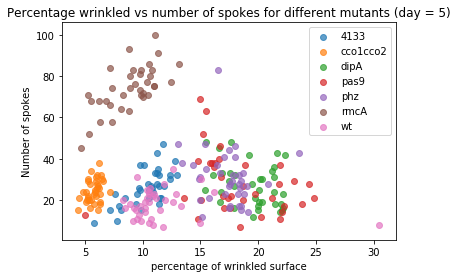

In [13]:
day = 5
fig, ax = plt.subplots()
for mutant in np.unique(df_features.mutant):
    data = df_features[(df_features.mutant == mutant) & (df_features.day == day)]
    ax.scatter(data.percent_wrinkled, data.n_spokes,  label = mutant, alpha = 0.7)
ax.set_xlabel("percentage of wrinkled surface")
ax.set_ylabel("Number of spokes")
ax.legend()
plt.title('Percentage wrinkled vs number of spokes for different mutants (day = {})'.format(day))
plt.show()

## Data Representation and Dimenstion Reduction on day 4 and day 5 images

We use unsupervised dimensionality reduction techniques to visualize all images in one graphic.

#### tSNE representation

First attempt at visualization in low dimension is to use tSNE. THough this did give some resulting similarities in the visualization, the results were difficult to replicate and clusters were not clear. 

In [14]:
tsne_names = []
tsne_data = []
for name in all_images:
    if int(name.split('_')[1])>3:
        tsne_data.append(all_images[name])
        tsne_names.append(name)
labels = np.array([name.split('_')[0] for name in tsne_names])

In [15]:
X = [x.flatten() for x in tsne_data]
X = np.asarray(X)

In [16]:
n_components = 50

print("Extracting the top %d eigenvectors from %d biofilms"
      % (n_components, X.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)
print("done in %0.3fs" % (time() - t0))


print("Projecting the input data on the eigen orthonormal basis")
t0 = time()

X_pca = pca.transform(X)
print("done in %0.3fs" % (time() - t0))

Extracting the top 50 eigenvectors from 512 biofilms
done in 19.055s
Projecting the input data on the eigen orthonormal basis
done in 1.657s


In [17]:
feat_cols = [ 'pixel'+str(i) for i in range(X_pca.shape[1]) ]

df = pd.DataFrame(X_pca,columns=feat_cols)
df['label'] = labels

X, y = None, None


print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (512, 51)


In [18]:
rndperm = np.random.permutation(df.shape[0])

n_sne = 1000

time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 512 samples in 0.001s...
[t-SNE] Computed neighbors for 512 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 512 / 512
[t-SNE] Mean sigma: 1.688991
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.309547
[t-SNE] KL divergence after 300 iterations: 2.439730
t-SNE done! Time elapsed: 0.7327215671539307 seconds


In [19]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

In [20]:

p = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.6) \
        + ggtitle("tSNE dimensions colored by gene")\
        + theme_bw() 

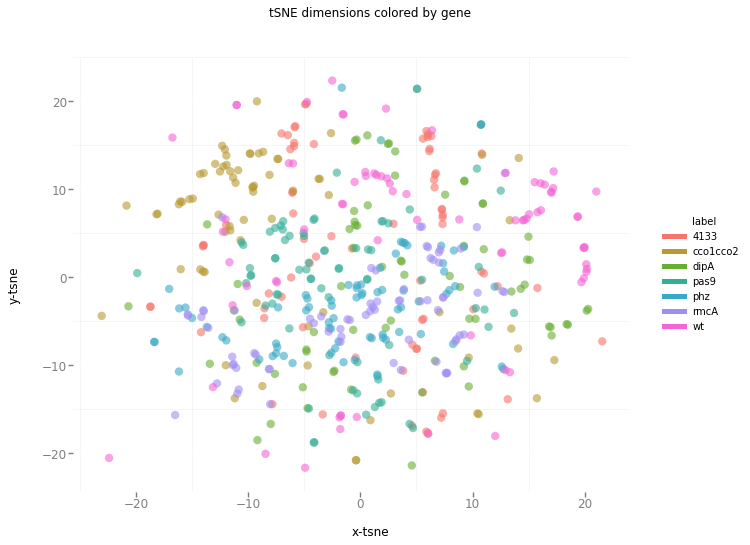

<ggplot: (-9223363265315833470)>

In [21]:
p


### UMAP representation
Following the mild success of tSNE, we implement a UMAP embedding, with PCA as a preprocessing step. 

We go from original dimensionality to 50 Principle components, then to 2 components for the UMAP visualization

In [22]:
umap_embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.001,
                      metric='correlation').fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

#### Parameter Search

Cycle through parameter values and combinations of n_neighbors and min_dist. Visually inspect the results to determine best clustering. 

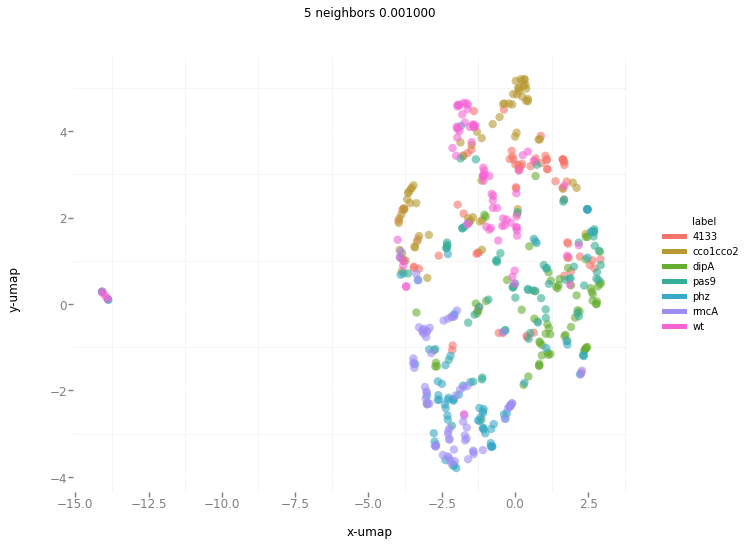

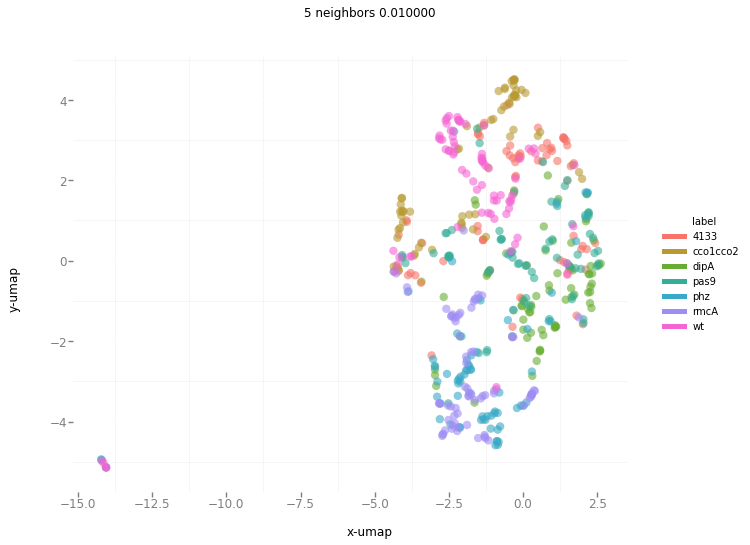

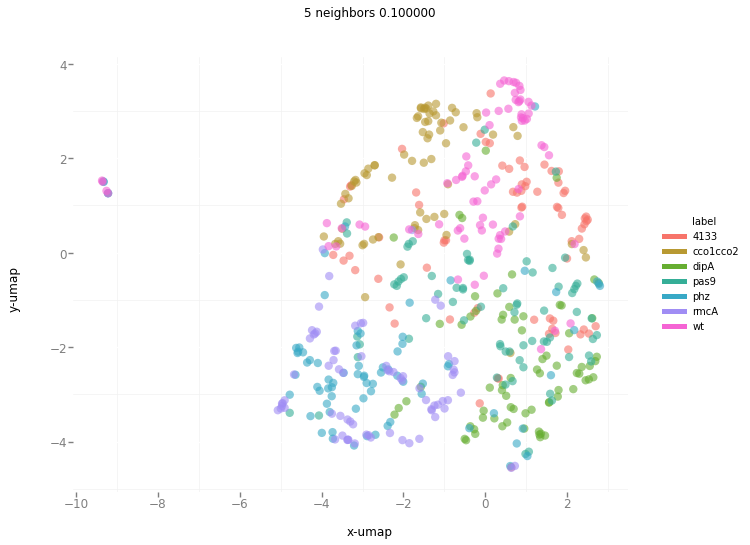

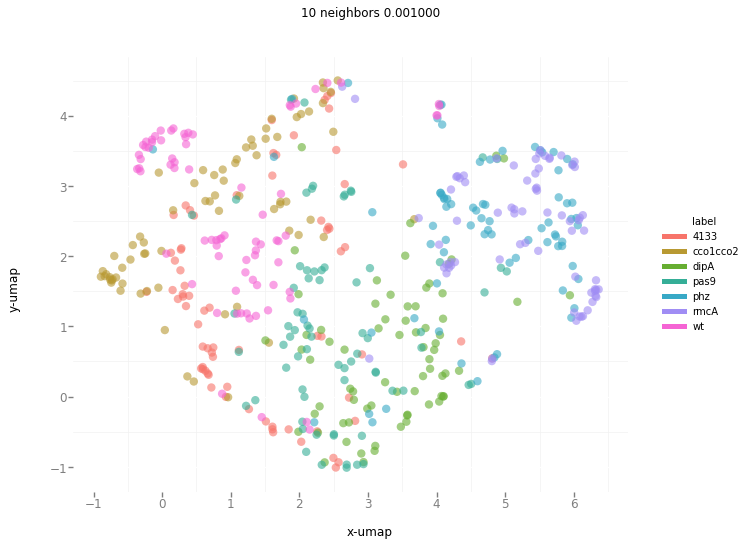

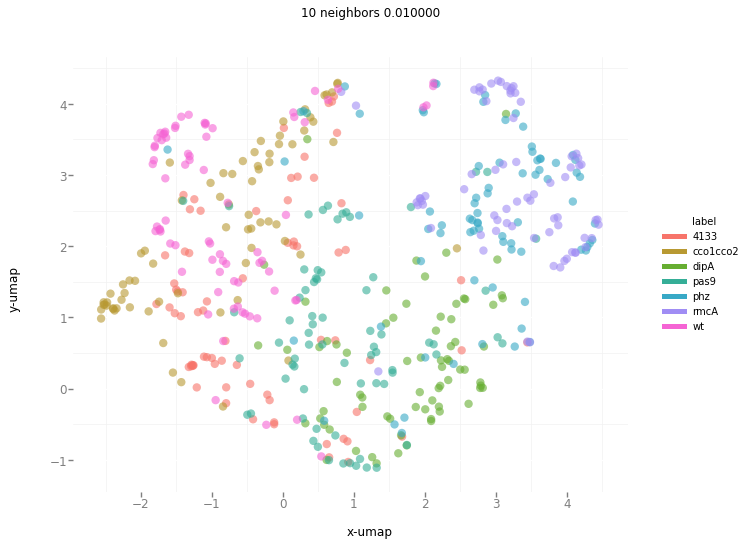

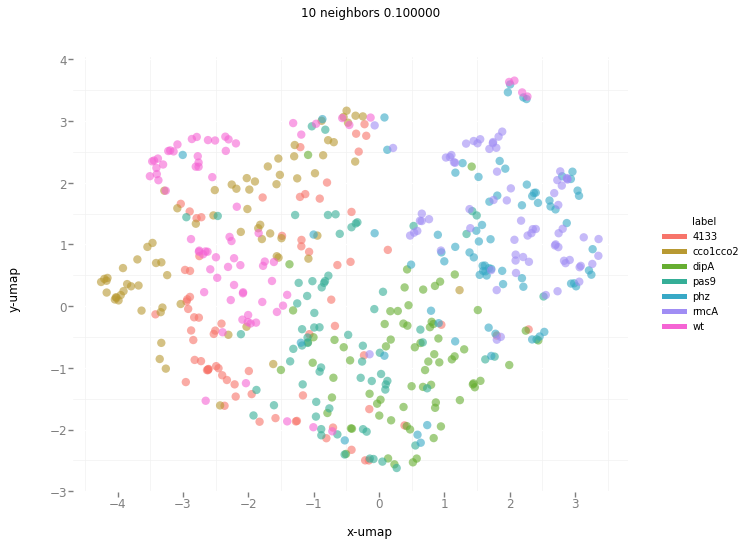

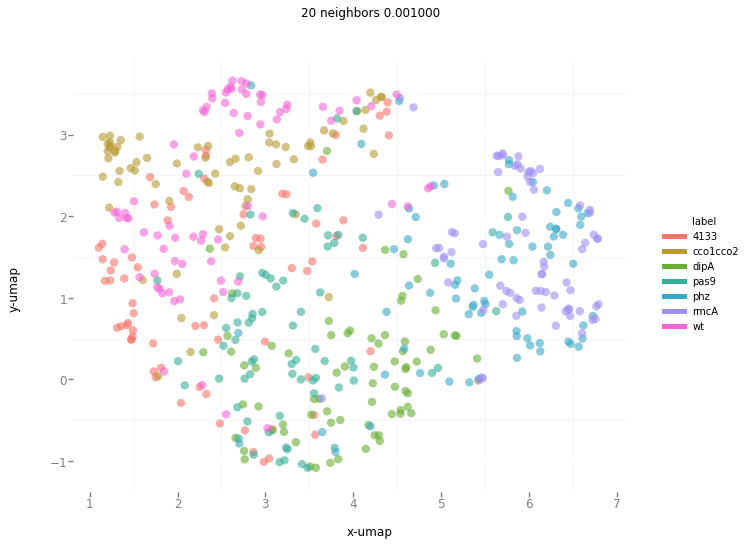

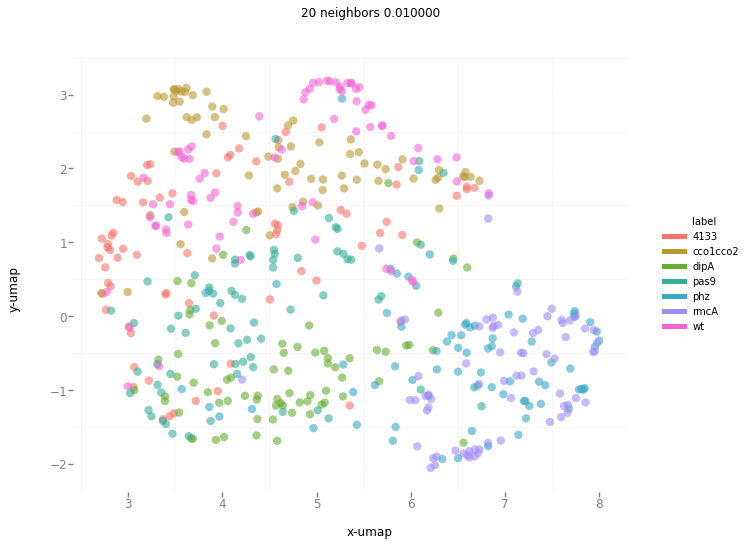

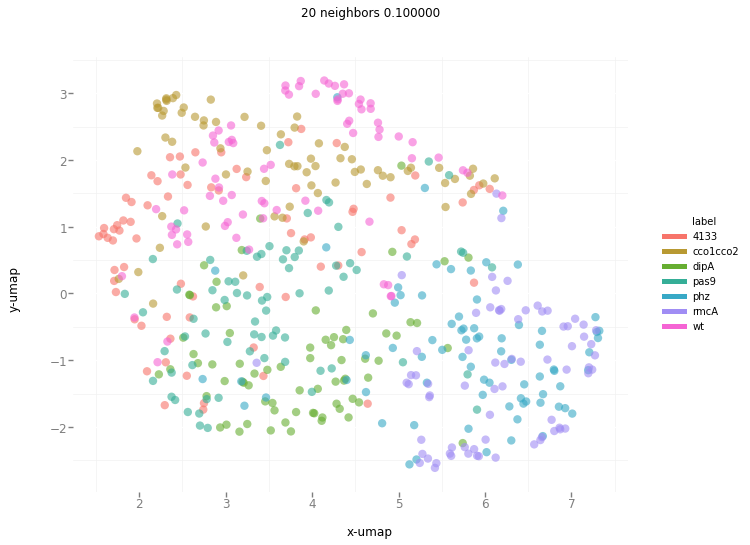

In [23]:
for n in [5,10,20]:
    for m in [.001, .01, .1]:
        umap_embedding = umap.UMAP(n_neighbors=n,
                          min_dist=m,
                          metric='correlation').fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
        df_umap = df.loc[rndperm[:n_sne],:].copy()
        df_umap['x-umap'] = umap_embedding[:,0]
        df_umap['y-umap'] = umap_embedding[:,1]
        p = ggplot( df_umap, aes(x='x-umap', y='y-umap', color='label') ) \
            + geom_point(size=70,alpha=0.6) \
            + ggtitle("%d neighbors %f" %(n,m)) \
            + theme_bw()
        p.show()

By visual inspection, determine the best parameter values and rerun with those values 

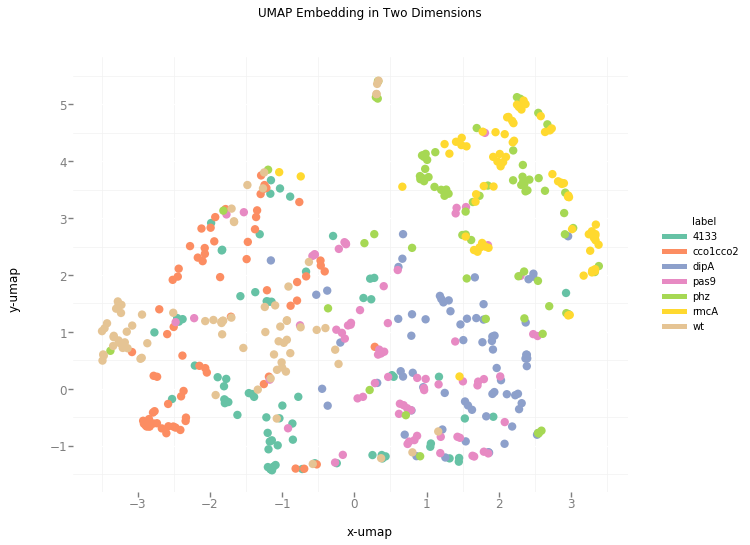

In [24]:
umap_embedding = umap.UMAP(n_neighbors=7,
                  min_dist=.005,
                  metric='correlation').fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)
df_umap = df.loc[rndperm[:n_sne],:].copy()
df_umap['x-umap'] = umap_embedding[:,0]
df_umap['y-umap'] = umap_embedding[:,1]
p = ggplot( df_umap, aes(x='x-umap', y='y-umap', color='label') ) \
    + geom_point(size=70,alpha=1) \
    + ggtitle("UMAP Embedding in Two Dimensions") \
    + theme_bw() \
    + scale_color_brewer(type='qual', scheme='Dark',palette=7, n=7)
p.show()